# stakcing(randomforest, xgboost) example on kaggle titanic dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# 1. feature engineering & impute missing values

In [6]:
predictors = ['Pclass', 'Title', 'Sex', 'AgeClass', 'FamilySize', 'Fare', 'Cabin', 'Embarked']

### Title

In [7]:
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

In [8]:
df_train['Title'] = df_train['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
df_train['Title'] = df_train['Title'].map(Title_Dictionary)

df_test['Title'] = df_test['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
df_test['Title'] = df_test['Title'].map(Title_Dictionary)

### AgeClass

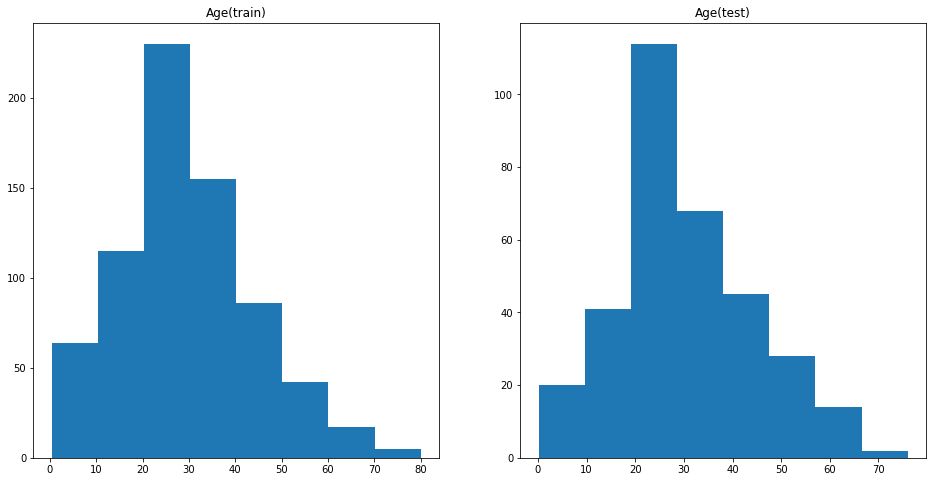

In [9]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.hist(df_train['Age'].dropna(), bins=8)
ax1.set_title('Age(train)')
ax2.hist(df_test['Age'].dropna(), bins=8)
ax2.set_title('Age(test)')
plt.show()

In [10]:
df_train['AgeClass'] = df_train['Age'].astype('object')
df_train.loc[df_train['Age'].isnull(), 'AgeClass'] = 'unkown'
df_train.loc[df_train['Age']<10, 'AgeClass'] = '<10'
df_train.loc[(df_train['Age']>=10)&(df_train['Age']<20), 'AgeClass'] = '10-20'
df_train.loc[(df_train['Age']>=20)&(df_train['Age']<30), 'AgeClass'] = '20-30'
df_train.loc[(df_train['Age']>=30)&(df_train['Age']<40), 'AgeClass'] = '30-40'
df_train.loc[(df_train['Age']>=40)&(df_train['Age']<50), 'AgeClass'] = '40-50'
df_train.loc[(df_train['Age']>=50), 'AgeClass'] = '>50'

df_test['AgeClass'] = df_test['Age'].astype('object')
df_test.loc[df_test['Age'].isnull(), 'AgeClass'] = 'unkown'
df_test.loc[df_test['Age']<10, 'AgeClass'] = '<10'
df_test.loc[(df_test['Age']>=10)&(df_test['Age']<20), 'AgeClass'] = '10-20'
df_test.loc[(df_test['Age']>=20)&(df_test['Age']<30), 'AgeClass'] = '20-30'
df_test.loc[(df_test['Age']>=30)&(df_test['Age']<40), 'AgeClass'] = '30-40'
df_test.loc[(df_test['Age']>=40)&(df_test['Age']<50), 'AgeClass'] = '40-50'
df_test.loc[(df_test['Age']>=50), 'AgeClass'] = '>50'

### FamilySize

In [11]:
df_train['FamilySize'] = df_train['Parch'] + df_train['SibSp']
df_test['FamilySize'] = df_test['Parch'] + df_test['SibSp']

### Fare

In [12]:
train_fare_mean = df_train['Fare'].mean()
df_test['Fare'] = df_test['Fare'].fillna(train_fare_mean)

### Cabin

In [13]:
cabin_unknown = 'U'
df_train['Cabin'] = df_train['Cabin'].fillna(cabin_unknown)
df_test['Cabin'] = df_test['Cabin'].fillna(cabin_unknown)
df_train['Cabin'] = df_train['Cabin'].apply(lambda cabin: cabin[0])
df_test['Cabin'] = df_test['Cabin'].apply(lambda cabin: cabin[0])

### Embarked

In [14]:
train_embarked_mode = df_train['Embarked'].mode()[0]
df_train['Embarked'] = df_train['Embarked'].fillna(train_embarked_mode)

In [15]:
df_train[predictors].head()

,Pclass,Title,Sex,AgeClass,FamilySize,Fare,Cabin,Embarked
0,3,Mr,male,20-30,1,7.2500,U,S
1,1,Mrs,female,30-40,1,71.2833,C,C
2,3,Miss,female,20-30,0,7.9250,U,S
3,1,Mrs,female,30-40,1,53.1000,C,S
4,3,Mr,male,30-40,0,8.0500,U,S


# 2. transform dataframe to numeric numpy array

* train, test data should be numeric numpy array

In [16]:
numeric_columns = df_train[predictors].select_dtypes(include=[np.number]).columns.values
categorical_columns = df_train[predictors].select_dtypes(include=[np.object]).columns.values
print(numeric_columns)
print(categorical_columns)

['Pclass' 'FamilySize' 'Fare']
['Title' 'Sex' 'AgeClass' 'Cabin' 'Embarked']


### categorical to numeric

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in categorical_columns:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

In [18]:
df_train[predictors].head()

,Pclass,Title,Sex,AgeClass,FamilySize,Fare,Cabin,Embarked
0,3,2,1,1,1,7.2500,8,2
1,1,3,0,2,1,71.2833,2,0
2,3,1,0,1,0,7.9250,8,2
3,1,3,0,2,1,53.1000,2,2
4,3,2,1,2,0,8.0500,8,2


### categorical to one hot encoding

In [19]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

X_train = ohe.fit_transform(df_train[categorical_columns])
X_test = ohe.transform(df_test[categorical_columns])

### full train, test numpy array [numerical features + one hot encoded categorical features]

In [20]:
X_train = np.hstack((df_train[numeric_columns].values, X_train))
X_test = np.hstack((df_test[numeric_columns].values, X_test))

y_train = df_train['Survived'].values

In [21]:
print(X_train.shape, X_train.dtype)
print(X_test.shape, X_test.dtype)
print(y_train.shape)

(891, 30) float64
(418, 30) float64
(891,)


# 3. train machine learning model

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import StackingCVClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

SEED1 = 1993
SEED2 = 725
N_FOLDS = 3

In [23]:
rfc1 = RandomForestClassifier(random_state=SEED1)
rfc2 = RandomForestClassifier(random_state=SEED2)
xgb1 = XGBClassifier(seed=SEED1)
xgb2 = XGBClassifier(seed=SEED2)
lr = LogisticRegression()
sclf = StackingCVClassifier(n_folds=2, classifiers=[rfc1, rfc2, xgb1, xgb2], meta_classifier=lr, random_state=SEED1)

In [24]:
# simple check performance
for clf, label in zip([rfc1, rfc2, xgb1, xgb2, sclf], ['rfc1', 'rfc2', 'xgb1', 'xgb2', 'stacking']):
    scores = cross_val_score(clf, X_train, y_train, cv=N_FOLDS, scoring='accuracy')
    print("Accuracy: %.3f (+/- %.2f) [%s]" % 
         (scores.mean(), scores.std(), label))

Accuracy: 0.800 (+/- 0.01) [rfc1]
Accuracy: 0.795 (+/- 0.02) [rfc2]
Accuracy: 0.826 (+/- 0.01) [xgb1]
Accuracy: 0.826 (+/- 0.01) [xgb2]
Accuracy: 0.826 (+/- 0.01) [stacking]


In [25]:
params = {'randomforestclassifier-1__n_estimators': [10, 50],
          'randomforestclassifier-2__n_estimators': [100, 200],
          'xgbclassifier-1__n_estimators': [10, 50],
          'xgbclassifier-2__n_estimators': [100, 200]
         }

grid = GridSearchCV(estimator=sclf, param_grid=params, cv=N_FOLDS, refit=True, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   23.2s finished


Best parameters: {'randomforestclassifier-1__n_estimators': 10, 'randomforestclassifier-2__n_estimators': 200, 'xgbclassifier-1__n_estimators': 10, 'xgbclassifier-2__n_estimators': 200}
Accuracy: 0.82


# 4. submit predictions

In [26]:
y_pred = grid.predict(X_test)
submissions = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred})
submissions.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [27]:
submissions.to_csv('submissions.csv', index=False)